In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute

#X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
#Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))

X_motion = X_footsteps_accelerations_absolute
Y_motion = Y_footsteps_accelerations_absolute

print(X_motion.shape)
print(Y_motion.shape)

(5387, 24)
(5387, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where RL swings
idxs = np.where(X_motion[:, -1] == 1)[0]
X_motion_RL_swinging = X_motion[idxs]
Y_motion_RL_swinging = Y_motion[idxs]

## Predict RL foot -> x

In [8]:
X_motion_RL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.25694543,  0.12992343, -0.37906209,  0.2197057 ,
       -0.12563169, -0.37883392, -0.27589926,  0.12483438, -0.38819841,
       -0.24197114, -0.12696964, -0.38106376,  0.09454557,  0.02429993,
        0.00199516, -0.03199961,  0.        ,  1.        ])

In [9]:
X_motion_RL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.25694543,  0.12992343, -0.37906209,  0.2197057 ,
       -0.12563169, -0.37883392, -0.27589926,  0.12483438, -0.38819841,
       -0.24197114, -0.12696964, -0.38106376,  0.09454557,  0.02429993,
        0.00199516, -0.03199961,  0.        ,  1.        ])

### Linear Regression

In [15]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               X_motion_RL_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)

# Create the model
model_rl_relative_swinging_x = LinearRegression()

# Fit the model
model_rl_relative_swinging_x.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.992417805025199
RMSE:  0.014236091697265165
The lowest error is:  0.00014648258552740767
The highest error is:  0.05662613066155042
The avg. error is:  0.010614043636284782


In [16]:
model_rl_relative_swinging_x.coef_

array([[ 7.79802189e-03,  6.66133815e-16, -1.73472348e-16,
         8.26464943e-02, -1.45716772e-16, -3.88578059e-16,
         4.34497675e-01, -3.14847826e-01, -1.05995296e-01,
        -3.45420950e-02,  7.06510111e-01,  2.43376966e-01,
        -1.82229567e-01,  7.04716335e-01, -6.32295167e-01,
        -3.87117578e-02, -1.25555562e+00, -2.01462757e-01]])

In [17]:
model_rl_relative_swinging_x.intercept_

array([-0.56056053])

Text(0, 0.5, 'Predictions')

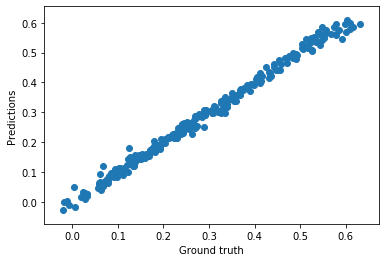

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

### Predict RL foot -> y

In [23]:
# Input
X = np.hstack((X_motion_RL_swinging[:, :3], # Previous motion command
               X_motion_RL_swinging[:, 3:6], # Current motion command
               X_motion_RL_swinging[:, 18:22], # Current CoM (x,y) veloctiy
               X_motion_RL_swinging[:, 6:8], # FL (x,y) position
               X_motion_RL_swinging[:, 9:11], # FR (x,y) position
               X_motion_RL_swinging[:, 12:14], # RL (x,y) position
               X_motion_RL_swinging[:, 15:17])) # RR (x, y) position

# Target
Y = np.array([Y_motion_RL_swinging[:, 3]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_rl_relative_swinging_y = LinearRegression()

# Fit the model
model_rl_relative_swinging_y.fit(X_train, Y_train)

# Predict
predictions = model_rl_relative_swinging_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.2915846987434745
RMSE:  0.007446177397972165
The lowest error is:  7.975811063237748e-06
The highest error is:  0.04110343313730597
The avg. error is:  0.005636537642458711


In [24]:
model_rl_relative_swinging_y.coef_

array([[ 5.34008225e-03,  1.58727198e-16, -4.00287442e-16,
         2.04006133e-02, -5.55111512e-16, -2.77555756e-16,
        -4.67513343e-02,  3.45903178e-02,  1.00038210e-02,
        -3.39628381e-03, -7.25649871e-02,  2.66127522e-01,
         1.53824492e-01, -6.69291976e-02, -1.25680840e-01,
        -1.64627201e+00,  2.21972692e-01,  4.46878327e-01]])

In [25]:
model_rl_relative_swinging_y.intercept_

array([0.23246413])

Text(0, 0.5, 'Predictions')

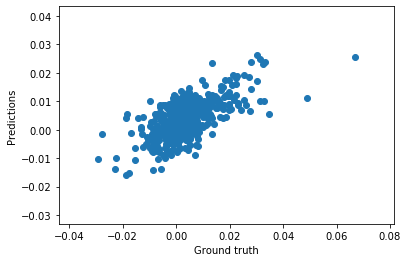

In [26]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [27]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')